In [1]:

from flow_stress.flow_stress import *#FlowStressCalculator, plot_strain_slip_rates

In [2]:
%pwd

u'/Users/bmelosh/projects/flowstress'

In [3]:

temp = range(300, 600)
pressure = [400]
grain_size = range(3, 35, 3)#range(5,10)#[10,12,13,16,27,29]##[5,6,7,8,9,10,11,12,13,14,15,30] #List of grainsizes 
width = [30]


In [4]:
f = FlowStressCalculator(temp,pressure)
fugacity = f.calculate_fugacity()

differential_stress = f.calculate_differential_stress(grain_size)#, paleopiezometer = 'T77')

strain_rate= f.calculate_strain_rate()

slip_rate = f.calculate_slip_rate(width)


#convert K back to C for plotting
temperature_C = K2C(f.temperature)


/Users/bmelosh/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


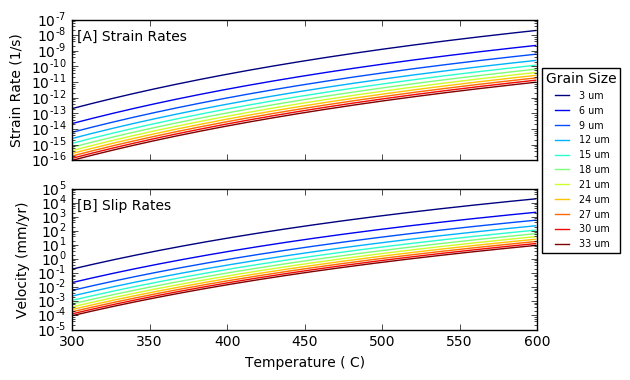

In [5]:
plot_strain_slip_rates(f.temperature, strain_rate, slip_rate, grain_size)

In [6]:
from matplotlib.backends.backend_pdf import PdfPages
from flowstress.flowstress import export_pdf

# fig = plot_strain_slip_rates(f.temperature, strain_rate, slip_rate)
# fig.set_size_inches(9,6)
# export_pdf(fig, 'strain_slip_rates')

ImportError: No module named flowstress.flowstress

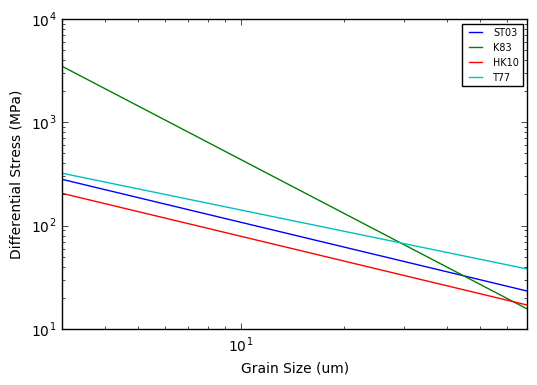

In [7]:
#plotting piezometers
import matplotlib.pyplot as plt
from flow_stress.flow_stress import PIEZOMETERS, FLOW_LAWS
temp = [450]
grain_size =range(3,70)
pressure = [400]

fig = plt.figure()
plt.yscale('log')
plt.xscale('log')

plt.xlabel('Grain Size (um)')
plt.ylabel('Differential Stress (MPa)')

for key in PIEZOMETERS:
    f = FlowStressCalculator(temp,pressure)
    f.calculate_fugacity()
    ds = f.calculate_differential_stress(grain_size, paleopiezometer = key)

    plt.plot(grain_size, ds, label=key)
    plt.xlim([min(grain_size),max(grain_size)])

    
plt.legend(loc='upper right', fontsize = 'x-small')
plt.show()

In [9]:
#EXTRA STUFF, that might be of interest from other notebooks

#HOW TO, Share plot x axis
plt.setp(sub1.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace = 0.001)

#HOW TO, iterate through linestyles
colors = iter(cm.gray(np.linspace(0, 1, len(v))))#set color ramp to jet with a line spacing of length e
lstyles=[':', '-.', '--', '-', ':', '-.', '--', '-',':' ]

#HOW TO, write a test without testtutils

s = 84

T = temp_conv(450)

x = np.power(s,4)
y = np.power(300,1)
z = np.exp(-135000/(8.3144598*T))
e = 6.3E-12*x*y*z
v = 30000*31536000*e

#how to write a test!
def test_calculate_slip_rate():
    w = 30000
    e = 2.043722042401592e-11
    slip_rate = calculate_slip_rate(e, w)
    assert slip_rate == 19.335245498752982
test_calculate_slip_rate()



NameError: name 'sub1' is not defined